In [1]:
import cv2
import numpy as np
import glob
import matplotlib.pyplot as plt
import pickle
%matplotlib inline

In [2]:
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1,2)
# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.
# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')
# Step through the list and search for chessboard corners
for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6), None)
    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)
        # Draw and display the corners
        cv2.drawChessboardCorners(img, (9,6), corners, ret)
        #write_name = 'corners_found'+str(idx)+'.jpg'
        #cv2.imwrite(write_name, img)
        #plt.imshow(img)
        #cv2.waitKey(500)
#cv2.destroyAllWindows()

Text(0.5,1,'Undistorted Image')

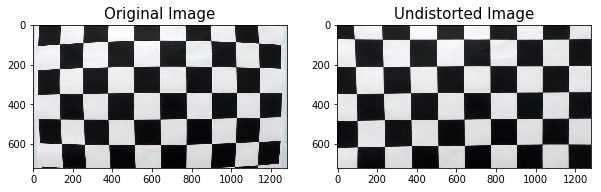

In [3]:
# Test undistortion on any image from calibration folder
img = cv2.imread('camera_cal/calibration1.jpg')
img_size = (img.shape[1], img.shape[0])

# Using camera calibration function given object points and image points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)

dst = cv2.undistort(img, mtx, dist, None, mtx)
cv2.imwrite('camera_cal/test_undist1.jpg',dst)

# Save the camera calibration result for later use 
dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
pickle.dump( dist_pickle, open( "camera_cal/wide_dist_pickle.p", "wb" ) )
#dst = cv2.cvtColor(dst, cv2.COLOR_BGR2RGB)
# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=15)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=15)

In [4]:
img1 = cv2.imread('test_images/test1.jpg')
img1_size = (img.shape[1], img.shape[0])

dst1 = cv2.undistort(img1, mtx, dist, None, mtx)
cv2.imwrite('output_images/test1_undist.jpg',dst1)

True

In [5]:
def undistort(img):
    # this function returns the undistorted image
    # Camera matrix k    
    K = mtx
    # distortion coefficients d
    d = dist
    h, w = img.shape[:2]
    newcameramatrix, roi = cv2.getOptimalNewCameraMatrix(K, d, (w,h), 0,(w,h))
    dst = cv2.undistort(img, K, d, None, newcameramatrix)
    return dst

In [6]:
def image_processing(img, sthreshold = (120, 240), sxthreshold =(20, 100)):
      
    # Undistorting the image 
    img = undistort(img)
    img = np.copy(img)
    
    # Converting to HLS color space and separate the L channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    (h, l, s) = cv2.split(hls)
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    # calculating derivate in x direction using Sobel filter
    sobel_x = cv2.Sobel(gray, cv2.CV_64F, 1, 0) 
    absolute_sobel = np.absolute(sobel_x) 
    scale_sobel = np.uint8(255*absolute_sobel/np.max(absolute_sobel))

    sobel_y = cv2.Sobel(gray, cv2.CV_64F, 0, 1) 
    absolute_sobel_y = np.absolute(sobel_y) 
    scale_sobel_y = np.uint8(255*absolute_sobel_y/np.max(absolute_sobel_y))
    
    # Threshold x gradient
    sx_binary = np.zeros_like(scale_sobel)
    sx_binary[(scale_sobel >= sxthreshold[0]) & (scale_sobel <= sxthreshold[1])] = 1

    sythreshold = [20,150]
    sy_binary = np.zeros_like(scale_sobel_y)
    sy_binary[(scale_sobel >= sythreshold[0]) & (scale_sobel <= sythreshold[1])] = 1
    
    # Threshold s_channel
    sbinary = np.zeros_like(s)
    sbinary[(l >= sthreshold[0]) & (l <= sthreshold[1])] = 1
   # clr = np.dstack((np.zeros_like(sx_binary), sx_binary, sbinary)) * 255
    img_comb = np.zeros_like(sx_binary)
    img_comb[((sbinary==1) | (sx_binary == 1))] = 1
    return img_comb 


# proc1 = cv2.imread('test_images/test5.jpg')
# proc1 = cv2.cvtColor(proc1,cv2.COLOR_BGR2RGB)

# proc1_ = image_processing(proc1)
# plt.figure()
# plt.imshow(proc1_,cmap='gray')
# cv2.imwrite('output_images/test5_processed_challenge.jpg',proc1_)

In [7]:
def perspective_warp(img):
    # For calculating the perspective transform 
    h,w = img.shape[:2]
    pts_src = np.float32([[550,500],[780, 500],[1250,720],[135, 720]])
    pts_dst = np.float32([[0,0],[w, 0],[w,h],[0, h]])
    P = cv2.getPerspectiveTransform(pts_src, pts_dst) 
    warp = cv2.warpPerspective(img, P, (img.shape[1],img.shape[0]))
    return warp
def inv_perspective_warp(img):
    # For calculating the inverse perspective transform 
    h,w = img.shape[:2]
    pts_src = np.float32([[550,500],[780, 500],[1250,720],[135, 720]])
    pts_dst = np.float32([[0,0],[w, 0],[w,h],[0, h]])
    P = cv2.getPerspectiveTransform(pts_src, pts_dst) 
    warp = cv2.warpPerspective(img, np.linalg.inv(P), (img.shape[1],img.shape[0]))
    return warp

def get_hist(img):
    # Calculating the histogram
    hist = np.sum(img[img.shape[0]//2:,:], axis=0)
    return hist



In [8]:
# test_img=cv2.imread("test_images/test1.jpg")
# test_img = cv2.cvtColor(test_img,cv2.COLOR_BGR2RGB)
# plt.imshow(test_img)

left_p, left_q, left_r = [],[],[]
right_p, right_q, right_r = [],[],[]

def windows(img, min_pix = 1, margin=100,num_wind=9, windows_flag = True):
    global left_p, left_q, left_r,right_p, right_q, right_r 
    l_point= np.empty(3)
    r_point = np.empty(3)
    out_img = np.dstack((img, img, img))*255

    histogram = get_hist(img)
    # find peaks of left and right halves
    mid_point = int(histogram.shape[0]/2)
    
    # Creating the base of bins/windows for  left and right lanes
    left_bin_base = np.argmax(histogram[:mid_point])
    right_bin_base = np.argmax(histogram[mid_point:]) + mid_point
    
    # Creating empty lists to receive left and right lane pixel indices
    leftlane_indices = []
    rightlane_indices = []
    
    # Setting the height of windows
    bin_h = np.int(img.shape[0]/num_wind)
    
    # Finding the x and y positions of all nonzero pixels
    pixel_indices = img.nonzero()
    pixel_y = np.array(pixel_indices[0])
    pixel_x = np.array(pixel_indices[1])
    
    # Current position to be updated for each window
    current_bin_left = left_bin_base
    current_bin_right = right_bin_base
    
    # Iterating over the bins/windows
    for w in range(num_wind):
        # Identify window boundaries in x and y (and right and left)
        w_y_bottom = img.shape[0] - (w +1)*bin_h
        w_y_top = img.shape[0] - w * bin_h
        
        w_xleft_bottom = current_bin_left - margin
        w_xleft_top = current_bin_left + margin
        
        w_xright_bottom = current_bin_right - margin
        w_xright_top = current_bin_right + margin
        
        # Draw the windows on the  image
        if windows_flag == True:
            cv2.rectangle(out_img,(w_xleft_bottom,w_y_bottom),(w_xleft_top,w_y_top),
            (100,255,255), 3) 
            cv2.rectangle(out_img,(w_xright_bottom,w_y_bottom),(w_xright_top,w_y_top),
            (100,255,255), 3) 
            
        # Finding the nonzero pixels in x and y within the window
        req_left_pixels = ((pixel_y >= w_y_bottom) & (pixel_y < w_y_top) & 
        (pixel_x >= w_xleft_bottom) &  (pixel_x < w_xleft_top)).nonzero()[0]
        
        req_right_pixels = ((pixel_y >= w_y_bottom) & (pixel_y < w_y_top) & 
        (pixel_x >= w_xright_bottom) &  (pixel_x < w_xright_top)).nonzero()[0]
        
        # Append these indices to the corresponding lists
        leftlane_indices.append(req_left_pixels)
        rightlane_indices.append(req_right_pixels)
        
        # If we found > minpix pixels, recenter next window on their mean position
        if len(req_left_pixels) > min_pix:
            current_bin_left = np.int(np.mean(pixel_x[req_left_pixels]))
        if len(req_right_pixels) > min_pix:        
            current_bin_right = np.int(np.mean(pixel_x[req_right_pixels]))
     
        
   # Concatenate the arrays of left and right lane pixel indices
    leftlane_indices = np.concatenate(leftlane_indices)
    rightlane_indices = np.concatenate(rightlane_indices)

    # Calculating the left and right lane pixel positions
    leftlane_x_pixels = pixel_x[leftlane_indices]
    leftlane_y_pixels = pixel_y[leftlane_indices] 
    
    rightlane_x_pixels = pixel_x[rightlane_indices]
    rightlane_y_pixels = pixel_y[rightlane_indices] 

    # Fitting a second order polynomial to each lane
    leftlane_fit = np.polyfit(leftlane_y_pixels, leftlane_x_pixels, 2)
    rightlane_fit = np.polyfit(rightlane_y_pixels, rightlane_x_pixels, 2)
    
    left_p.append(leftlane_fit[0])
    left_q.append(leftlane_fit[1])
    left_r.append(leftlane_fit[2])
    
    right_p.append(rightlane_fit[0])
    right_q.append(rightlane_fit[1])
    right_r.append(rightlane_fit[2])
    
    l_point[0] = np.mean(left_p[-10:])
    l_point[1] = np.mean(left_q[-10:])
    l_point[2] = np.mean(left_r[-10:])
    
    r_point[0] = np.mean(right_p[-10:])
    r_point[1] = np.mean(right_q[-10:])
    r_point[2] = np.mean(right_r[-10:])
    
    # Generating x and y values for plotting
    y_values = np.linspace(0, img.shape[0]-1, img.shape[0] )
    leftlane_fit_x = l_point[0]*y_values**2 + l_point[1]*y_values + l_point[2]
    rightlane_fit_x = r_point[0]*y_values**2 + r_point[1]*y_values + r_point[2]

    out_img[pixel_y[leftlane_indices], pixel_x[leftlane_indices]] = [255, 0, 100]
    out_img[pixel_y[rightlane_indices], pixel_x[rightlane_indices]] = [0, 100, 255]
    
    return out_img, (leftlane_fit_x, rightlane_fit_x), (l_point, r_point), y_values


In [9]:
def get_polynomial(img, leftlane_x_pixels, rightlane_x_pixels):
    y_values = np.linspace(0, img.shape[0]-1, img.shape[0])
    y_eval = np.max(y_values)
    y_unit_pix = 30.5/720 # meters per pixel in y direction
    x_unit_pix = 3.7/720 # meters per pixel in x direction

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(y_values*y_unit_pix, leftlane_x_pixels*x_unit_pix, 2)
    right_fit_cr = np.polyfit(y_values*y_unit_pix, rightlane_x_pixels*x_unit_pix, 2)
    
    # Calculate the new radii of curvature for lanes
    left_curve_rad = ((1 + (2*left_fit_cr[0]*y_eval*y_unit_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curve_rad = ((1 + (2*right_fit_cr[0]*y_eval*y_unit_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    
    # Getting the car center position
    car_center_pos = img.shape[1]/2      
    l_fit_x_int = left_fit_cr[0]*img.shape[0]**2 + left_fit_cr[1]*img.shape[0] + left_fit_cr[2]
    r_fit_x_int = +right_fit_cr[0]*img.shape[0]**2 + right_fit_cr[1]*img.shape[0] + right_fit_cr[2]
    
    # Getting the lane center position
    lane_center_pos = (r_fit_x_int + l_fit_x_int) /2
    center = (car_center_pos - lane_center_pos) * x_unit_pix / 10
   
    # Now our radius of curvature is in meters
    return (left_curve_rad, right_curve_rad, center)

def draw_lanes(img, leftlane_fit_x, rightlane_fit_x):
    # Plotting the x and y values
    y_values = np.linspace(0, img.shape[0]-1, img.shape[0])
    color_img = np.zeros_like(img)
    
    left_lane = np.array([np.transpose(np.vstack([leftlane_fit_x - 20, y_values]))])
    right_lane = np.array([np.flipud(np.transpose(np.vstack([rightlane_fit_x, y_values])))])
    lane_points = np.hstack((left_lane, right_lane))
    
    cv2.fillPoly(color_img, np.int_(lane_points), (0,150,0))

    inv_perspective = inv_perspective_warp(color_img)
    inv_perspective = cv2.addWeighted(img, 1, inv_perspective, 0.7, 0)
    return inv_perspective


In [10]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [11]:
cap = cv2.VideoCapture('challenge_video.mp4')

def process_image(image):
    #_,frame = image.read()
    orig_frame = image.copy()
    img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    # Calling the perspective_warp function
    warp = perspective_warp(img)
    # Performing the required image processing steps 
    dst = image_processing(warp)
    
    slide_img, lanes, curve, y_vales = windows(dst)
    curve_radius = get_polynomial(dst, lanes[0],lanes[1])
    
    img_ = draw_lanes(image, lanes[0], lanes[1])
    lane_curve = np.mean([curve_radius[0], curve_radius[1]])
    
    # For displaying the text on the frame of the video
    font = cv2.FONT_HERSHEY_SIMPLEX
    fontColor = (0, 0, 0)
    fontSize=0.5
    cv2.putText(img_, 'Lane Curvature: {:.0f} m'.format(lane_curve), (570, 610), font, fontSize, fontColor, 2)
   
    offset = curve_radius[2]
    cv2.putText(img_, 'Center Offset: {:.3f} m'.format(offset), (570, 630), font, fontSize, fontColor, 2)
    
    font = cv2.FONT_HERSHEY_SIMPLEX
    fontColor = (0, 0, 0)
    fontSize=0.5
    ###===Printing the turning instruction===###
    if offset < 0:
        if offset < -0.1:
            cv2.putText(img_, 'Turn instructions: Left ', (570, 650), font, fontSize, fontColor, 2)
        else:
            cv2.putText(img_, ' Keep Straight ', (570, 650), font, fontSize, fontColor, 2)
    else:
        if offset > 0.1:
            cv2.putText(img_, 'Turn instructions: Right ', (570, 650), font, fontSize, fontColor, 2)
        else:
            cv2.putText(img_, ' Keep Straight ', (570, 650), font, fontSize, fontColor, 2)
        
#     if offset <= 0.22:
#         cv2.putText(img_, 'Turn instructions: Right ', (570, 650), font, fontSize, fontColor, 2)
#     elif offset > 0.40:
#         cv2.putText(img_, 'Turn instructions: Left ', (570, 650), font, fontSize, fontColor, 2)

    return img_

#     plt.figure()
#     plt.imshow(img_, cmap='hsv')
#     if cv2.waitKey(30) & 0xFF == ord('q'):
#         break



In [14]:
white_output = 'test_videos_output/harder_challenge_video.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("harder_challenge_video.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/harder_challenge_video.mp4
[MoviePy] Writing video test_videos_output/harder_challenge_video.mp4


100%|█████████▉| 1199/1200 [10:31<00:00,  3.59it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/harder_challenge_video.mp4 

CPU times: user 3min 18s, sys: 51.1 s, total: 4min 9s
Wall time: 10min 34s


In [15]:
white_output = 'test_videos_output/harder_challenge_video.mp4'

HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))